In [1]:
from collections import namedtuple
from os import listdir

import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import numpy as np
import sys


%load_ext autoreload
%autoreload 2

sys.path.append('../PSO/pso/src/pso/')

# Atom structure

In [2]:
Atom = namedtuple('Atom', ['name', 'element', 'aminoacid', 'x', 'y', 'z', 'residue_seq_number'])

Atom.parse_name = lambda string: string[12:16].strip()
Atom.parse_element = lambda string: string[12] if len(string.strip()) < 78 \
                     else string[76:78].strip()
Atom.parse_aminoacid = lambda string: string[17:20].strip()
Atom.parse_x = lambda string: float(string[30:38].strip())
Atom.parse_y = lambda string: float(string[38:46].strip())
Atom.parse_z = lambda string: float(string[46:54].strip())
Atom.parse_residue_seq_number = lambda string: int(string[23:30].strip())

Atom.parse = lambda string: Atom(
    Atom.parse_name(string), Atom.parse_element(string), Atom.parse_aminoacid(string),
    Atom.parse_y(string), Atom.parse_x(string), Atom.parse_z(string), Atom.parse_residue_seq_number(string))

## Select the molecule to compare

In [3]:
path_molecules_to_compare = [f for f in listdir() 
                             if 'reference' not in f and f.endswith('.pdb')]
print(path_molecules_to_compare)

['1ACW-01.pdb', '1ACW-02.pdb', '1ACW-03.pdb', '1ACW-04.pdb', '1ACW-05.pdb', '1ACW-06.pdb']


## Read data from pdb file

In [4]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                try:
                    atoms.append(Atom.parse(line))
                except Exception as e:
                    print(e)
    return atoms

In [5]:
reference = pd.DataFrame(read_molecule('reference.pdb'))
molecules_to_compare = [pd.DataFrame(read_molecule(m)) \
                        for m in path_molecules_to_compare]

In [6]:
molecules_to_compare[0][:20]

,name,element,aminoacid,x,y,z,residue_seq_number
0,N,N,VAL,-2.044,-1.352,0.000,1
1,H1,H,VAL,-1.261,-1.990,0.000,1
2,H2,H,VAL,-2.540,-1.446,0.875,1
3,H3,H,VAL,-2.540,-1.446,-0.875,1
4,CA,C,VAL,-1.523,0.000,0.000,1
5,HA,H,VAL,-1.871,0.524,0.890,1
6,CB,C,VAL,-1.989,0.768,-1.232,1
7,HB,H,VAL,-3.078,0.814,-1.241,1
8,CG1,C,VAL,-1.500,0.056,-2.490,1
9,HG11,H,VAL,-0.411,0.010,-2.481,1


In [25]:
reference[:50]

,name,element,aminoacid,x,y,z,residue_seq_number
0,N,N,VAL,0.298,0.965,-0.467,1
1,CA,C,VAL,0.250,1.811,-1.701,1
2,C,C,VAL,0.400,3.290,-1.320,1
3,O,O,VAL,1.053,3.628,-0.346,1
4,CB,C,VAL,1.384,1.417,-2.664,1
5,CG1,C,VAL,1.262,-0.064,-3.035,1
6,CG2,C,VAL,2.744,1.666,-2.002,1
7,H1,H,VAL,1.180,1.151,0.051,1
8,H2,H,VAL,0.255,-0.040,-0.731,1
9,H3,H,VAL,-0.512,1.196,0.142,1


# RMSD calculation

* We can notice that the reference structure has a greater number of alpha carbons and amino acids residues.


* One approach to tackle this problem would be to `trim` the reference molecule so it will have the same amount of alpha carbons than the molecule to compare.


a) At first, we'll compute the RMSD using the beginning of the molecule reference. 



b) After, the same study will be made with the possibility of translations in the molecule to be compared. 

In [8]:
def apply_transformations(transformation, df):
    homogeneous_coordinates = df[['x', 'y', 'z']].copy()
    homogeneous_coordinates['_'] = 1.0
    return transformation.dot(homogeneous_coordinates.values.T).T[:, :-1]

In [9]:
def RMSD(molecule1, molecule2, functions=['CA'], 
         transformation1=np.eye(4), transformation2=np.eye(4)):
    
    molecule1 = molecule1[molecule1.name.isin(functions)].copy()
    molecule1 = apply_transformations(transformation1, molecule1)
    molecule2 = molecule2[molecule2.name.isin(functions)].copy()
    molecule2  = apply_transformations(transformation2, molecule2)
    
    smaller_size = min(len(molecule1), len(molecule2))
    squared_differences = (molecule1[:smaller_size] - \
                           molecule2[:smaller_size]) ** 2

    squared_distance = squared_differences.sum(axis=1)
    average_squared_distance = squared_distance.mean()
    average_distance = np.sqrt(average_squared_distance)
    return average_distance

## No Translation

Not applying any transfomation.
RMSD between the reference and molecule 1: 23.519198 Ångströns
RMSD between the reference and molecule 2: 35.708949 Ångströns
RMSD between the reference and molecule 3: 23.615692 Ångströns
RMSD between the reference and molecule 4: 20.787576 Ångströns
RMSD between the reference and molecule 5: 22.118981 Ångströns
RMSD between the reference and molecule 6: 25.326716 Ångströns


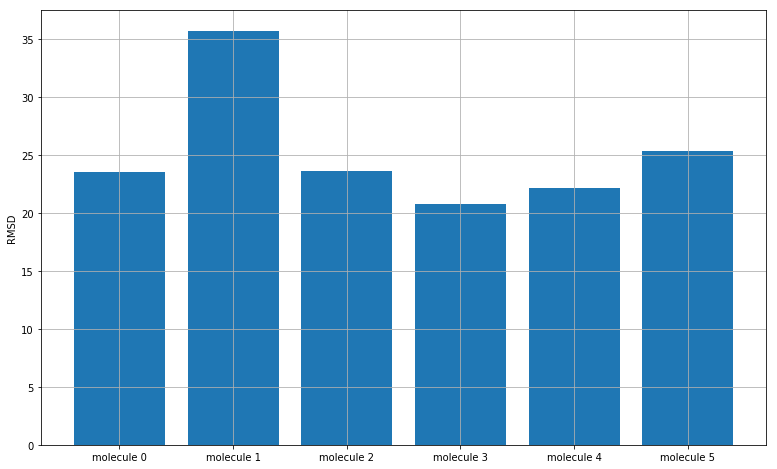

In [10]:
print('Not applying any transfomation.')
rmsd = []
labels = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    rmsd.append(RMSD(reference, molecules_to_compare[idx]))
    labels.append('molecule %d' % idx)
    print('RMSD between the reference and molecule %d: %f Ångströns' % \
          (idx + 1, rmsd[-1]))
    

plt.figure(figsize=(13, 8))
plt.ylabel('RMSD')
plt.bar(labels, rmsd)
plt.grid()
plt.show()

## With translation.

In [11]:
def infer_translation_matrix(molecule_to_be_displaced, ref_point):
    atom_to_displace =\
        molecule_to_be_displaced[molecule_to_be_displaced.name == 'CA'].iloc[0]
    
    T_MATRIX = np.eye(4)
    T_MATRIX[0, 3] = (ref_point.x - atom_to_displace.x)
    T_MATRIX[1, 3] = (ref_point.y - atom_to_displace.y)
    T_MATRIX[2, 3] = (ref_point.z - atom_to_displace.z)
    return T_MATRIX

* At first, we'll consider as a reference point the first carbon alpha of the molecule reference.

In [12]:
ref_point = reference[reference.name == 'CA'].iloc[0]

RMSD between the reference and molecule 1: 23.214202 Ångströns
RMSD between the reference and molecule 2: 33.803276 Ångströns
RMSD between the reference and molecule 3: 24.416573 Ångströns
RMSD between the reference and molecule 4: 19.721576 Ångströns
RMSD between the reference and molecule 5: 23.510216 Ångströns
RMSD between the reference and molecule 6: 25.992975 Ångströns


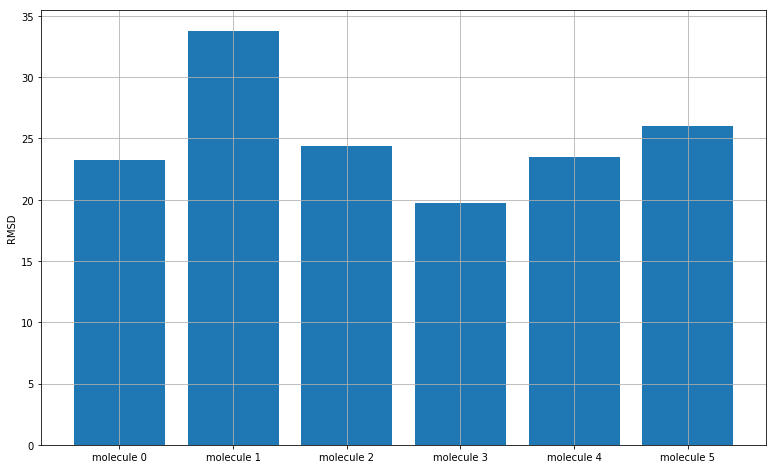

In [13]:
rmsd = []
labels = []
for idx, molecule_to_compare in enumerate(molecules_to_compare):
    translation = infer_translation_matrix(molecule_to_compare, ref_point)
    rmsd.append(RMSD(reference, molecules_to_compare[idx], transformation2=translation))
    labels.append('molecule %d' % idx)
    print('RMSD between the reference and molecule %d: %f Ångströns' % \
          (idx + 1, rmsd[-1]))
    

plt.figure(figsize=(13, 8))
plt.ylabel('RMSD')
plt.bar(labels, rmsd)
plt.grid()
plt.show()

That's it!

***
---
***
---
***
---
***

***
---
***
---
***
---
***

# Calculating the best alignment.

* We will be using the library `pso` developed by assignee of this assignment.


* The PSO (Particle swarm optimization) is an heuristic method for finding global minima in cost/energy functions.


* For the molecule alignment problem, the **RMSD** is going to be the cost function that we want to minimize.


* The library requires an structure called `CostModel`, which defines the objective function, the boundaries and the number of parameters.

In [107]:
NUMBER_OF_PARTICLES = 10

In [14]:
from cost import CostModel
from pso import PSO
from plot import plot_states
from functools import partial

In [15]:
ref_point = reference[reference.name == 'CA'].iloc[0]
print('Reference point: ')
ref_point

Reference point: 


name                     CA
element                   C
aminoacid               VAL
x                      0.25
y                     1.811
z                    -1.701
residue_seq_number        1
Name: 1, dtype: object

In [82]:
boundary_min = reference[['x', 'y','z']].values.min() * 2
boundary_max = reference[['x', 'y','z']].values.max() * 2
print('Translation boundaries (twice as much as the absolute maximum of each coordinate): ')
print('min: ', boundary_min, 'Ångströns')
print('max: ', boundary_max, 'Ångströns')

Translation boundaries (twice as much as the absolute maximum of each coordinate): 
min:  -45.464 Ångströns
max:  35.752 Ångströns


## b) Optimize RMSD taking into account only the alpha carbons.



In [19]:
def translation_matrix(delta_x, delta_y, delta_z, ref_x=.0, ref_y=.0, ref_z=.0):
    T = np.eye(4)
    T[0, -1], T[1, -1], T[2, -1] = delta_x - ref_x, delta_y - ref_y, delta_z - ref_z
    return T

In [20]:
idx = 0
cost_model = CostModel(
    callable=lambda T:\
        RMSD(reference, molecules_to_compare[idx], 
             transformation1=np.eye(4),
             transformation2=translation_matrix(T[0], T[1], T[2], ref_x=ref_point.x, ref_y=ref_point.y, ref_z=ref_point.z)),
    num_dimensions=3,
    parameters_boundaries=[boundary_min, boundary_max],
    name='RMSD between reference and molecule %d.' % idx
)

pso = PSO(cost_model, num_particles=NUMBER_OF_PARTICLES, max_iter=500, min_cummulative_error=1E-2)
states = pso.optimize()

### Cumulative RMSD of all particles

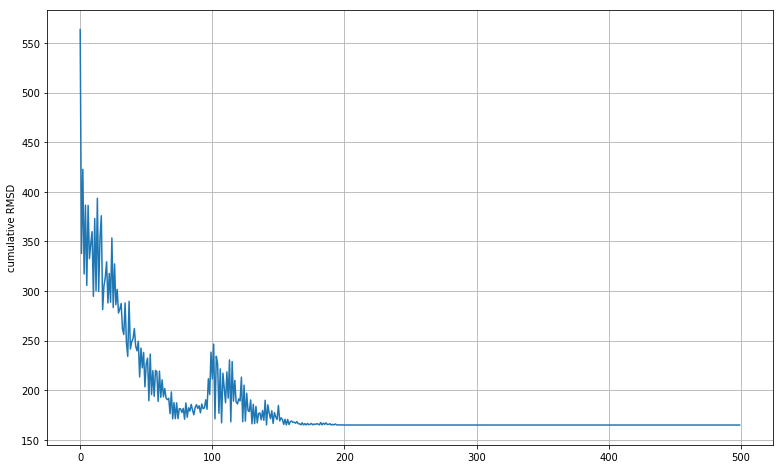

Final cumulative RMSD: 164.96934628565134


In [81]:
plt.figure(figsize=(13, 8))
plt.ylabel('cumulative RMSD')
plt.plot(states['cumulative_error'])
plt.grid()
plt.show()
print('Final cumulative RMSD:', states['cumulative_error'][-1])

### RMSD of all the average position of all particles.

In [74]:
average_positions = np.array([np.mean(np.vstack(list(particles_position.values())), axis=0) for particles_position in states['particles_positions']])

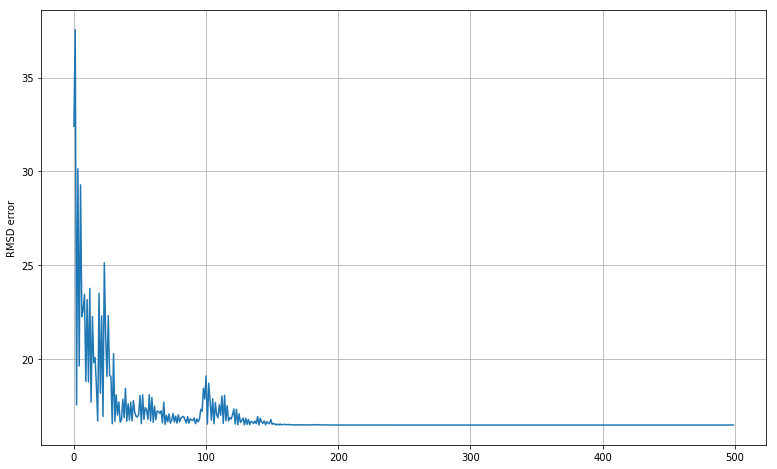

Final average RMSD: 16.496934628385436
Final average translation: [13.42978811  4.74583236  8.23296543] Ångströns


In [106]:
rmsd = [cost_model.callable(average_position) for average_position in average_positions]
plt.figure(figsize=(13, 8))
plt.ylabel('RMSD error')
plt.plot(rmsd)
plt.grid()
plt.show()
print('Final average RMSD:', rmsd[-1])
print('Final average translation:', average_positions[-1, :], 'Ångströns')